# Setting enviroment

In [13]:
%reload_ext kedro.ipython

[01/01/25 18:07:45] INFO     Registered line magic '%reload_kedro'                                   ]8;id=700876;file:///home/bruno/Documents/Programming/Programming_projects/olist_project/.venv/lib/python3.11/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=89198;file:///home/bruno/Documents/Programming/Programming_projects/olist_project/.venv/lib/python3.11/site-packages/kedro/ipython/__init__.py#61\61]8;;\

                    INFO     Registered line magic '%load_node'                                      ]8;id=885003;file:///home/bruno/Documents/Programming/Programming_projects/olist_project/.venv/lib/python3.11/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=794002;file:///home/bruno/Documents/Programming/Programming_projects/olist_project/.venv/lib/python3.11/site-packages/kedro/ipython/__init__.py#63\63]8;;\

                    INFO     Resolved project path as:                                              ]8;id=978099;file:///home/bruno/Documents/Programming/Programming_projects/olist_project/.venv/lib/python3.11/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=18972;file:///home/bruno/Documents/Programming/Programming_projects/olist_project/.venv/lib/python3.11/site-packages/kedro/ipython/__init__.py#178\178]8;;\
                             /home/bruno/Documents/Programming/Programming_projects/olist_project.                 
                             To set a different path, run '%reload_kedro <project_root>'                           

[01/01/25 18:07:46] INFO     Kedro is sending anonymous usage data with the sole purpose of improving ]8;id=175459;file:///home/bruno/Documents/Programming/Programming_projects/olist_project/.venv/lib/python3.11/site-packages/kedro_telemetry/plugin.py\plugin.py]8;;\:]8;id=225213;file:///home/bruno/Documents/Programming/Programming_projects/olist_project/.venv/lib/python3.11/site-packages/kedro_telemetry/plugin.py#233\233]8;;\
                             the product. No personal data or IP addresses are stored on our side. If              
                             you want to opt out, set the `KEDRO_DISABLE_TELEMETRY` or `DO_NOT_TRACK`              
                             environment variables, or create a `.telemetry` file in the current                   
                             working directory with the contents `consent: false`. Read more at                    
                             https://docs.kedro.org/en/stable/configuration/telemetry.html                         

                    INFO     Kedro project olist_project                                            ]8;id=455204;file:///home/bruno/Documents/Programming/Programming_projects/olist_project/.venv/lib/python3.11/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=583718;file:///home/bruno/Documents/Programming/Programming_projects/olist_project/.venv/lib/python3.11/site-packages/kedro/ipython/__init__.py#144\144]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=472106;file:///home/bruno/Documents/Programming/Programming_projects/olist_project/.venv/lib/python3.11/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=265616;file:///home/bruno/Documents/Programming/Programming_projects/olist_project/.venv/lib/python3.11/site-packages/kedro/ipython/__init__.py#145\145]8;;\
                             'pipelines'                                                                           

                    INFO     Registered line magic 'run_viz'                                        ]8;id=146438;file:///home/bruno/Documents/Programming/Programming_projects/olist_project/.venv/lib/python3.11/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=537089;file:///home/bruno/Documents/Programming/Programming_projects/olist_project/.venv/lib/python3.11/site-packages/kedro/ipython/__init__.py#151\151]8;;\

In [24]:
import warnings
import string
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
import mlflow
import optbinning
from sklearn.preprocessing import QuantileTransformer
from sklearn.calibration import calibration_curve,CalibratedClassifierCV
from feature_engine.discretisation import EqualFrequencyDiscretiser
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

In [15]:
mlflow_tracking_uri = context.project_path.as_uri()+'/mlflow'
mlflow.set_tracking_uri(mlflow_tracking_uri)

# Functions

In [16]:

def download_mlflow_model(run_id):
    model_uri = f'runs:/{run_id}/model'
    model = mlflow.sklearn.load_model(model_uri=model_uri)
    return model

def get_feature_names_in_model(run_id):
    return list(download_mlflow_model(run_id).feature_names_in_)

def calculate_probas(model,X_dev,y_dev,X_oot):
    
    variables = model.feature_names_in_

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        skf = StratifiedKFold(5)
        y_proba_oos = cross_val_predict(model, X_dev[variables], y_dev,
                                        method='predict_proba', cv=skf)[:,1]
    y_proba_train = model.predict_proba(X_dev[variables])[:,1]
    y_proba_oot = model.predict_proba(X_oot[variables])[:,1]

    y_proba_train = pd.Series(y_proba_train, index=X_dev.index, name='proba')
    y_proba_oos = pd.Series(y_proba_oos, index=X_dev.index, name='proba')
    y_proba_oot = pd.Series(y_proba_oot, index=X_oot.index, name='proba')
    return y_proba_train,y_proba_oos,y_proba_oot

def calulate_scores(y_proba_train,y_proba_oos,y_proba_oot,
                    y_train,y_oos,y_oot,
                    random_state,
                    fit_type='train'):
    
    y_proba_train_df = pd.DataFrame({'proba': y_proba_train},
                                    index=y_train.index)
    y_proba_oos_df = pd.DataFrame({'proba': y_proba_oos},
                                    index=y_oos.index)
    y_proba_oot_df = pd.DataFrame({'proba': y_proba_oot},
                                    index=y_oot.index)
    quant_transf = QuantileTransformer(random_state=random_state).set_output(transform='pandas')
    if fit_type == 'train':
        quant_transf.fit(y_proba_train_df)
    elif fit_type == 'oos':
        quant_transf.fit(y_proba_oos_df)
    elif fit_type == 'oot':
        quant_transf.fit(y_proba_oot_df)
    score_train = (1-pd.Series(quant_transf.transform(y_proba_train_df).proba,
                               index=y_train.index, name='score'))*1000
    score_oos = (1-pd.Series(quant_transf.transform(y_proba_oos_df).proba,
                             index=y_oos.index, name='score'))*1000
    score_oot = (1-pd.Series(quant_transf.transform(y_proba_oot_df).proba,
                             index = y_oot.index, name='score'))*1000

    return score_train, score_oos, score_oot

def calulate_scores_2(y_proba_train,y_proba_oos,y_proba_oot,
                      y_train,y_oos,y_oot,
                      random_state, fit_type='train'):
    
    y_proba_train_df = pd.DataFrame({'pre_score': (1-y_proba_train)*1000},
                                    index=y_train.index)
    y_proba_oos_df = pd.DataFrame({'pre_score': (1-y_proba_oos)*1000},
                                  index=y_oos.index)
    y_proba_oot_df = pd.DataFrame({'pre_score': (1-y_proba_oot)*1000},
                                  index=y_oot.index)
    
    quant_transf = QuantileTransformer(random_state=random_state).set_output(transform='pandas')
    if fit_type == 'train':
        quant_transf.fit(y_proba_train_df)
    elif fit_type == 'oos':
        quant_transf.fit(y_proba_oos_df)
    elif fit_type == 'oot':
        quant_transf.fit(y_proba_oot_df)
    score_train = pd.Series(quant_transf.transform(y_proba_train_df).pre_score,
                            index=y_train.index, name='score')
    score_oos = pd.Series(quant_transf.transform(y_proba_oos_df).pre_score,
                          index=y_oos.index, name='score')
    score_oot = pd.Series(quant_transf.transform(y_proba_oot_df).pre_score,
                          index=y_oot.index, name='score')

    return score_train, score_oos, score_oot

def calulate_scores_3(y_proba_train,y_proba_oos,y_proba_oot,
                      y_train,y_oos,y_oot):
    
    score_train = pd.Series((1-y_proba_train)*1000,
                            index=y_train.index,
                            name='score')
    score_oos = pd.Series((1-y_proba_oos)*1000,
                             index=y_oos.index,
                             name='score')
    score_oot = pd.Series((1-y_proba_oot)*1000,
                             index=y_oot.index,
                             name='score')

    return score_train, score_oos, score_oot

def get_discretizers(score_train,y_dev,monotonic_trend='auto',
                     n_ratings=5,max_n_bins=None,min_n_bins=None,
                     min_event_rate_diff=0,
                     prebinning_method='cart', solver='cp', divergence='iv',
                     max_n_prebins=20, min_prebin_size=0.05, min_bin_size=None,
                     max_bin_size=None, min_bin_n_nonevent=None,
                     max_bin_n_nonevent=None, min_bin_n_event=None,
                     max_bin_n_event=None, max_pvalue=None,
                     max_pvalue_policy='consecutive', gamma=0,
                     outlier_detector=None, outlier_params=None, class_weight=None,
                     cat_cutoff=None, cat_unknown=None, user_splits=None,
                     user_splits_fixed=None, special_codes=None, split_digits=None,
                     mip_solver='bop', time_limit=100, verbose=False,
                     score_name='score'):
    if n_ratings is not None:
        max_n_bins = n_ratings
        min_n_bins = n_ratings
    disc_eq = EqualFrequencyDiscretiser(q=n_ratings,return_boundaries=True, precision=1)
    disc_eq.fit(score_train.rename(score_name).to_frame(),y_dev)
    faixas_eq = disc_eq.binner_dict_[score_name]
    disc_opt = optbinning.OptimalBinning(max_n_bins=max_n_bins,
                                         min_n_bins=min_n_bins,
                                         monotonic_trend=monotonic_trend,
                                         min_event_rate_diff=min_event_rate_diff,
                                         prebinning_method=prebinning_method,
                                         solver=solver,
                                         divergence=divergence,
                                         max_n_prebins=max_n_prebins,
                                         min_prebin_size=min_prebin_size,
                                         min_bin_size=min_bin_size,
                                         max_bin_size=max_bin_size,
                                         min_bin_n_nonevent=min_bin_n_nonevent,
                                         max_bin_n_nonevent=max_bin_n_nonevent,
                                         min_bin_n_event=min_bin_n_event,
                                         max_bin_n_event=max_bin_n_event,
                                         max_pvalue=max_pvalue,
                                         max_pvalue_policy=max_pvalue_policy,
                                         gamma=gamma,
                                         outlier_detector=outlier_detector,
                                         outlier_params=outlier_params,
                                         class_weight=class_weight,
                                         cat_cutoff=cat_cutoff,
                                         cat_unknown=cat_unknown,
                                         user_splits=user_splits,
                                         user_splits_fixed=user_splits_fixed,
                                         special_codes=special_codes,
                                         split_digits=split_digits,
                                         mip_solver=mip_solver,
                                         time_limit=time_limit,
                                         verbose=verbose)
    disc_opt.fit(score_train, y_dev)
    faixas_opt = [-np.inf] + disc_opt.splits.tolist() + [np.inf]
    return faixas_eq,faixas_opt

def calculate_ordenation_result(df_results,grupo_risco_col,
                                target_col, group_data=None,
                                plot_faixas=True,
                                max_score=1000):
    df_results = df_results.copy()
    if plot_faixas:
        risk_group_col = lambda df,max=max_score: (
            df[grupo_risco_col].astype('string')
            .str.replace(',',';',regex=False)
            .str.replace('.',',',regex=False)
            .str.replace('-inf','0',regex=False)
            .str.replace('inf',str(max_score),regex=False)
        )
    else:
        df_results[grupo_risco_col] = df_results[grupo_risco_col].astype('string').str.split('=').str[0]
        risk_group_col = lambda df: df[grupo_risco_col]

    assign_cols = {
        'Inadimplência': lambda df: df.default,
        'Grupo de risco': lambda df: risk_group_col(df),
        'Volume': lambda df: df.volume,
        'volume_inad': lambda df: df.default * df.volume,
        'Inadimplência Geral': lambda df: (df.volume_inad).sum()/df.volume.sum(),
        'Volume relativo': lambda df: df.volume/df.volume.sum(),
        'Volume acumulado': lambda df: df.Volume.cumsum(),
        'Volume acumulado relativo': lambda df: df['Volume acumulado'] / df.Volume.sum(),
    }
    final_cols = ['Grupo de risco','Inadimplência',
                  'Inadimplência Geral','Volume','Volume relativo',
                  'Volume acumulado', 'Volume acumulado relativo']
    assign_group_cols = {}
    if group_data:
        assign_group_cols = {
            f'Volume por {group_data}': lambda df: (
                df.groupby(group_data).volume.transform('sum')
            ),
            f'Inadimplência geral por {group_data}': lambda df: (
                df.groupby(group_data).volume_inad.transform('sum') /
                df.groupby(group_data).volume.transform('sum')
            ),
            f'Volume relativo por {group_data}': lambda df: (
                df.volume/df.groupby(group_data).volume.transform('sum')
            ),
            f'Volume acumulado por {group_data}': lambda df: (
                df.groupby(group_data).Volume.transform('cumsum')
            ),
            f'Volume acumulado relativo por {group_data}': lambda df: (
                df.groupby(group_data).Volume.transform('cumsum') /
                df.groupby(group_data).Volume.transform('sum')
            )
        }
    group_data = [group_data] if group_data else []
    final_cols = group_data + final_cols
    assign_cols.update(assign_group_cols)
    final_cols = final_cols + list(assign_group_cols.keys())

    return (
        df_results
        .groupby(group_data+[grupo_risco_col], observed=False)
        .agg(
            default=(target_col,'mean'),
            volume=(target_col,'count'),
        )
        .reset_index()
        .sort_values(group_data+[grupo_risco_col], ascending=[True]*len(group_data+[grupo_risco_col]))
        # .sort_values(grupo_risco_col, ascending=False)
        .assign(**assign_cols)
        [final_cols]
    )

def calculate_ordenation_in_time_result(df_results,cohort_series,grupo_risco_col,
                                        target_col, group_data=None):
    group_data = [group_data] if group_data else []
    grupo_risco_col
    return (
        df_results
        .assign(**{
            'safra': cohort_series,
            grupo_risco_col: lambda df: df[grupo_risco_col].str.strip('=').str[0]
        })
        .groupby(group_data+[grupo_risco_col, 'safra'], observed=False)
        .agg(
            default=(target_col,'mean'),
            volume=(target_col,'count'),
        )
        .reset_index()
        .sort_values(grupo_risco_col, ascending=False)
        .assign(**{
            'Inadimplência': lambda df: df.default,
            'Volume': lambda df: df.volume,
            'Grupo de risco': lambda df: (
                df[grupo_risco_col].astype('string')
                .str.replace(',',';',regex=False)
                .str.replace('.',',',regex=False)
                .str.replace('-inf','0',regex=False)
                .str.replace('inf','1000',regex=False)
            )
        })
        .pivot_table(index=group_data+['safra'],columns=['Grupo de risco'],values=['Inadimplência','Volume'],observed=False)
        .reset_index()
        # .sort_values(group_data+['Grupo de risco'])
    )

def get_labels_from_bin_cuts(bin_cuts, max_score = 1000):
    rating_names=string.ascii_uppercase[:len(bin_cuts)-1][::-1]
    labels = [f'{rating_name}=({inf_cut:.3f},{sup_cut:.3f}]' for rating_name,inf_cut,sup_cut in zip(rating_names,bin_cuts[:-1],bin_cuts[1:])]
    labels = [label.replace('-inf','0').replace('inf',str(max_score)) for label in labels]
    return labels

def get_ratings(score,bins_cut):
    max_score = 1000 if score.mean()>1 else  1
    return pd.cut(score, bins=bins_cut,
                  labels=get_labels_from_bin_cuts(bins_cut,max_score)).astype('string')

# Load data

In [17]:
random_state = catalog.load('params:random_state')
id_col = catalog.load('params:audience_building.id_col')
cohort_col = catalog.load('params:audience_building.cohort_col')
target_name = catalog.load('params:modeling.target')
X_dev = catalog.load("X_train")
y_dev = catalog.load("y_train")
y_dev = y_dev[target_name]
id_model_dev = catalog.load("id_model_train")
cohort_dev = pd.to_datetime(id_model_dev[cohort_col], format='%Y%m')

X_oot = catalog.load("X_test_oot")
y_oot = catalog.load("y_test_oot")
y_oot = y_oot[target_name]
id_model_oot = catalog.load("id_model_test_oot")
cohort_oot = pd.to_datetime(id_model_oot[cohort_col], format='%Y%m')

[01/01/25 18:07:47] INFO     Loading data from params:random_state (MemoryDataset)...           ]8;id=510305;file:///home/bruno/Documents/Programming/Programming_projects/olist_project/.venv/lib/python3.11/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=833521;file:///home/bruno/Documents/Programming/Programming_projects/olist_project/.venv/lib/python3.11/site-packages/kedro/io/data_catalog.py#389\389]8;;\

                    INFO     Loading data from params:audience_building.id_col                  ]8;id=206451;file:///home/bruno/Documents/Programming/Programming_projects/olist_project/.venv/lib/python3.11/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=909223;file:///home/bruno/Documents/Programming/Programming_projects/olist_project/.venv/lib/python3.11/site-packages/kedro/io/data_catalog.py#389\389]8;;\
                             (MemoryDataset)...                                                                    

                    INFO     Loading data from params:audience_building.cohort_col              ]8;id=837580;file:///home/bruno/Documents/Programming/Programming_projects/olist_project/.venv/lib/python3.11/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=39957;file:///home/bruno/Documents/Programming/Programming_projects/olist_project/.venv/lib/python3.11/site-packages/kedro/io/data_catalog.py#389\389]8;;\
                             (MemoryDataset)...                                                                    

                    INFO     Loading data from params:modeling.target (MemoryDataset)...        ]8;id=508880;file:///home/bruno/Documents/Programming/Programming_projects/olist_project/.venv/lib/python3.11/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=746481;file:///home/bruno/Documents/Programming/Programming_projects/olist_project/.venv/lib/python3.11/site-packages/kedro/io/data_catalog.py#389\389]8;;\

                    INFO     Loading data from X_train (ParquetDataset)...                      ]8;id=852717;file:///home/bruno/Documents/Programming/Programming_projects/olist_project/.venv/lib/python3.11/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=750647;file:///home/bruno/Documents/Programming/Programming_projects/olist_project/.venv/lib/python3.11/site-packages/kedro/io/data_catalog.py#389\389]8;;\

                    INFO     Loading data from y_train (ParquetDataset)...                      ]8;id=58039;file:///home/bruno/Documents/Programming/Programming_projects/olist_project/.venv/lib/python3.11/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=673709;file:///home/bruno/Documents/Programming/Programming_projects/olist_project/.venv/lib/python3.11/site-packages/kedro/io/data_catalog.py#389\389]8;;\

                    INFO     Loading data from id_model_train (ParquetDataset)...               ]8;id=60705;file:///home/bruno/Documents/Programming/Programming_projects/olist_project/.venv/lib/python3.11/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=329097;file:///home/bruno/Documents/Programming/Programming_projects/olist_project/.venv/lib/python3.11/site-packages/kedro/io/data_catalog.py#389\389]8;;\

                    INFO     Loading data from X_test_oot (ParquetDataset)...                   ]8;id=911620;file:///home/bruno/Documents/Programming/Programming_projects/olist_project/.venv/lib/python3.11/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=104801;file:///home/bruno/Documents/Programming/Programming_projects/olist_project/.venv/lib/python3.11/site-packages/kedro/io/data_catalog.py#389\389]8;;\

                    INFO     Loading data from y_test_oot (ParquetDataset)...                   ]8;id=134770;file:///home/bruno/Documents/Programming/Programming_projects/olist_project/.venv/lib/python3.11/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=352515;file:///home/bruno/Documents/Programming/Programming_projects/olist_project/.venv/lib/python3.11/site-packages/kedro/io/data_catalog.py#389\389]8;;\

                    INFO     Loading data from id_model_test_oot (ParquetDataset)...            ]8;id=332784;file:///home/bruno/Documents/Programming/Programming_projects/olist_project/.venv/lib/python3.11/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=779045;file:///home/bruno/Documents/Programming/Programming_projects/olist_project/.venv/lib/python3.11/site-packages/kedro/io/data_catalog.py#389\389]8;;\

# Load model

In [18]:
def load_mlflow_model(run_id):
    model_uri = f'runs:/{run_id}/model'
    model = mlflow.sklearn.load_model(model_uri=model_uri)
    return model
run_id = '698e53be0c034a859ae3b497a2c73fbb'
model = load_mlflow_model(run_id)
model

Pipeline(steps=[('cat_imputer',
                 CategoricalImputer(variables=['sel_seller_state'])),
                ('rare_encoder',
                 RareLabelEncoder(variables=['sel_seller_state'])),
                ('estimator',
                 LGBMClassifier(colsample_bytree=0.3598161213005806,
                                is_unbalance=True,
                                learning_rate=0.45494654431041925, max_depth=34,
                                min_child_samples=8, n_estimators=98,
                                num_leaves=116, random_state=42,
                                reg_alpha=0.0006508430841455098,
                                reg_lambda=0.005058716747318272,
                                subsample=0.951745820295062, subsample_freq=7,
                                verbosity=-1))])

# Definição de ratings

In [28]:
y_proba_train,y_proba_oos,y_proba_oot = calculate_probas(model,X_dev,y_dev,X_oot)
score_train, score_oos, score_oot = (
    calulate_scores(y_proba_train, y_proba_oos, y_proba_oot,
                    y_dev, y_dev, y_oot, random_state,
                    fit_type='oos')
)
faixas_eq_oos, faixas_opt_oos = get_discretizers(score_oos, y_dev,
                                                 n_ratings=7,
                                                 monotonic_trend='descending')

In [31]:
df_dev = (
    id_model_dev
    .assign(
        target = y_dev,
        proba = 1-y_proba_oos,
        score = score_oos,
        grupo_risco_opt_oos = lambda df: get_ratings(df.score,faixas_opt_oos),
        grupo_risco_eq_oos = lambda df: get_ratings(df.score,faixas_eq_oos),
    )
)

df_oot = (
    id_model_oot
    .assign(
        target = y_oot,
        proba = 1-y_proba_oot,
        score = score_oot,
        grupo_risco_opt_oos = lambda df: get_ratings(df.score,faixas_opt_oos),
        grupo_risco_eq_oos = lambda df: get_ratings(df.score,faixas_eq_oos),
    )
)

In [35]:
grupo_risco_col = 'grupo_risco_opt_oos'
target_col = 'target'
display(calculate_ordenation_result(df_dev, grupo_risco_col, target_col, plot_faixas=True))

,Grupo de risco,Inadimplência,Inadimplência Geral,Volume,Volume relativo,Volume acumulado,Volume acumulado relativo
0,"A=(894,851;1000]",0.002545,0.318024,786,0.105249,786,0.105249
1,"B=(595,898;894,851]",0.020161,0.318024,2232,0.298875,3018,0.404124
2,"C=(381,151;595,898]",0.056110,0.318024,1604,0.214783,4622,0.618907
3,"D=(311,507;381,151]",0.273077,0.318024,520,0.069630,5142,0.688538
4,"E=(257,750;311,507]",0.618454,0.318024,401,0.053696,5543,0.742234
5,"F=(207,432;257,750]",0.887701,0.318024,374,0.050080,5917,0.792314
6,"G=(0;207,432]",0.977434,0.318024,1551,0.207686,7468,1.000000


In [32]:
grupo_risco_col = 'grupo_risco_opt_oos'
target_col = 'target'
display(calculate_ordenation_result(df_oot, grupo_risco_col, target_col, plot_faixas=True))

,Grupo de risco,Inadimplência,Inadimplência Geral,Volume,Volume relativo,Volume acumulado,Volume acumulado relativo
0,"A=(894,851;1000]",0.007092,0.330445,141,0.081456,141,0.081456
1,"B=(595,898;894,851]",0.051230,0.330445,488,0.281918,629,0.363374
2,"C=(381,151;595,898]",0.107579,0.330445,409,0.236280,1038,0.599653
3,"D=(311,507;381,151]",0.202797,0.330445,143,0.082611,1181,0.682265
4,"E=(257,750;311,507]",0.633803,0.330445,142,0.082034,1323,0.764298
5,"F=(207,432;257,750]",0.909091,0.330445,110,0.063547,1433,0.827845
6,"G=(0;207,432]",0.949664,0.330445,298,0.172155,1731,1.000000


In [51]:
(
    catalog.load('results_test_oot')
    .groupby('rating', as_index=False,observed=False)
    .agg(
        volume = ('target_churn','count'),
        target_mean = ('target_churn','mean')
    )
    .sort_values('rating', ascending=False)
)

[01/01/25 18:34:03] INFO     Loading data from results_test_oot (ParquetDataset)...             ]8;id=684233;file:///home/bruno/Documents/Programming/Programming_projects/olist_project/.venv/lib/python3.11/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=963345;file:///home/bruno/Documents/Programming/Programming_projects/olist_project/.venv/lib/python3.11/site-packages/kedro/io/data_catalog.py#389\389]8;;\

,rating,volume,target_mean
6,A,141,0.007092
5,B,488,0.051230
4,C,409,0.107579
3,D,143,0.202797
2,E,142,0.633803
1,F,110,0.909091
0,G,298,0.949664


# Calibração

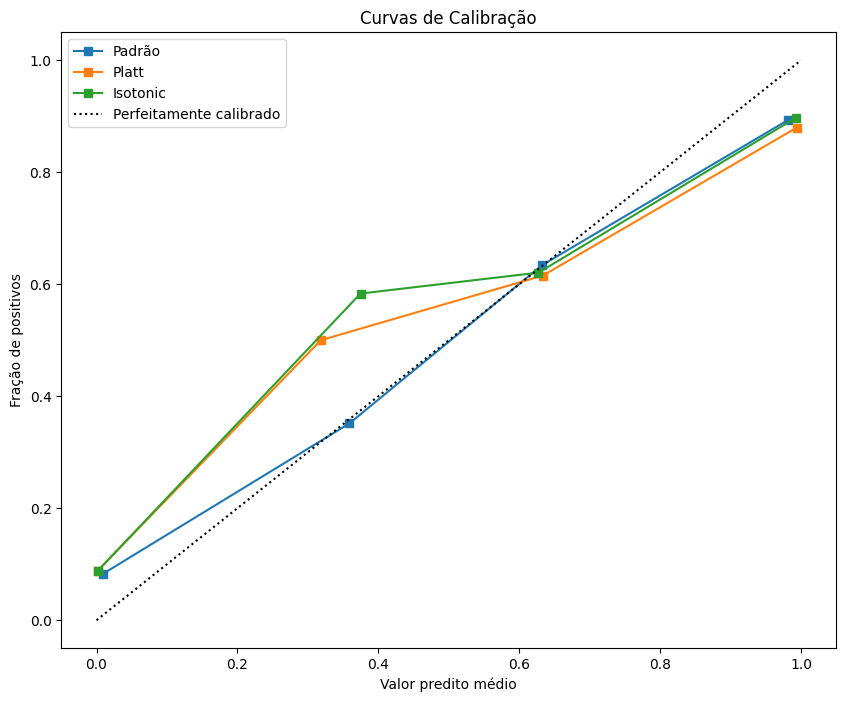

In [54]:
def plot_calibration_curve(model, X_train, y_train, X_test, y_test, n_bins=10):
    # Calibrate the model using Platt scaling and Isotonic regression
    platt_calibrated = CalibratedClassifierCV(model, method='sigmoid', cv='prefit')
    isotonic_calibrated = CalibratedClassifierCV(model, method='isotonic', cv='prefit')

    platt_calibrated.fit(X_train, y_train)
    isotonic_calibrated.fit(X_train, y_train)

    # Predict probabilities
    prob_pos = model.predict_proba(X_test)[:, 1]
    prob_pos_platt = platt_calibrated.predict_proba(X_test)[:, 1]
    prob_pos_isotonic = isotonic_calibrated.predict_proba(X_test)[:, 1]

    # Calibration curves
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=n_bins)
    fraction_of_positives_platt, mean_predicted_value_platt = calibration_curve(y_test, prob_pos_platt, n_bins=n_bins)
    fraction_of_positives_isotonic, mean_predicted_value_isotonic = calibration_curve(y_test, prob_pos_isotonic, n_bins=n_bins)

    # Plotting
    plt.figure(figsize=(10, 8))
    plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Padrão")
    plt.plot(mean_predicted_value_platt, fraction_of_positives_platt, "s-", label="Platt")
    plt.plot(mean_predicted_value_isotonic, fraction_of_positives_isotonic, "s-", label="Isotonic")
    plt.plot([0, 1], [0, 1], "k:", label="Perfeitamente calibrado")
    plt.ylabel("Fração de positivos")
    plt.xlabel("Valor predito médio")
    plt.title("Curvas de Calibração")
    plt.legend()
    plt.show()
    return isotonic_calibrated, platt_calibrated
# Usage example:
X_dev_new = X_dev[model.feature_names_in_]
X_oot_new = X_oot[model.feature_names_in_]
isotonic_calibrated, platt_calibrated = plot_calibration_curve(model,X_dev_new, y_dev, X_oot_new, y_oot, n_bins=4)